# **LSTM+CV**

***1. IMPORT PACKAGES AND LIBRARIES***

In [ ]:
import pandas as pd
from nltk import word_tokenize
from collections import Counter

***2. LOAD DATASET***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('sp_translated.csv')

In [ ]:
data

,Unnamed: 0,Fake,final_clean
0,0,0,intentar prender fuego espós ilesa gravemente ...
1,1,0,ese ser renaud vuelta escenario octubre acción...
2,2,0,traje rojo qué mensaje querer enviar hillary c...
3,3,0,footligar resultado octava jornada h octubre m...
4,4,0,suscríbete podcast poder suscribir él descarga...
...,...,...,...
5995,2966,0,consejo gobierno haber dar visto bueno convoca...
5996,2967,0,investigador valenciano haber desarrollar inno...
5997,2968,0,arrestado actuar coche establecimiento policia...
5998,2969,0,rey haber encargar miercol pedro sanchez prese...


In [ ]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
data['final_clean'].isnull().sum()

0

***3. CONVERT TO VECTORS***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(max_features=3000)
output=vectorizer.fit_transform(data['final_clean'])

In [ ]:
output

<6000x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 382511 stored elements in Compressed Sparse Row format>

***4. SPLIT DATA***

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(output.toarray(),data['Fake'].values,test_size=0.2,random_state=0)

***5. BUILD THE MODEL***

In [ ]:
#Creating the lstm model
from keras.models import Sequential
from keras.layers import Dense,Embedding, LSTM, RNN, Dropout
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,SGD

model=Sequential()
model.add(LSTM(100,input_shape=(1,3000))) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.2))
model.add(Dense(63, activation='relu',  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu',  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
#Compiling the model
adam=Adam(learning_rate=0.00001)
model.compile(adam, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               1240400   
                                                                 
 dropout_21 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 63)                6363      
                                                                 
 dropout_22 (Dropout)        (None, 63)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                2048      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 8)                

***6. RESHAPE AND TRAIN THE MODEL***

In [ ]:
X_train_new=X_train.reshape(X_train.shape[0],1,X_train.shape[1])

In [ ]:
X_train.shape

(4800, 3000)

In [ ]:
X_train_new.shape # convertir formato de la entrada a formato matriz (requerido por LSTM)

(4800, 1, 3000)

In [ ]:
X_train_new=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_valid_new=X_val.reshape(X_val.shape[0],1,X_val.shape[1])
history = model.fit(X_train_new,y_train,validation_data=(X_valid_new,y_val),epochs=200)

Epoch 1/200
150/150 [==============================] - 3s 7ms/step - loss: 2.0077 - accuracy: 0.5188 - val_loss: 1.9930 - val_accuracy: 0.5825
Epoch 2/200
150/150 [==============================] - 1s 4ms/step - loss: 1.9809 - accuracy: 0.5323 - val_loss: 1.9671 - val_accuracy: 0.5925
Epoch 3/200
150/150 [==============================] - 1s 4ms/step - loss: 1.9547 - accuracy: 0.5579 - val_loss: 1.9412 - val_accuracy: 0.6167
Epoch 4/200
150/150 [==============================] - 1s 4ms/step - loss: 1.9284 - accuracy: 0.5829 - val_loss: 1.9152 - val_accuracy: 0.6533
Epoch 5/200
150/150 [==============================] - 1s 4ms/step - loss: 1.9022 - accuracy: 0.6085 - val_loss: 1.8888 - val_accuracy: 0.6883
Epoch 6/200
150/150 [==============================] - 1s 4ms/step - loss: 1.8754 - accuracy: 0.6410 - val_loss: 1.8619 - val_accuracy: 0.7125
Epoch 7/200
150/150 [==============================] - 1s 4ms/step - loss: 1.8491 - accuracy: 0.6548 - val_loss: 1.8344 - val_accuracy: 0.7342

***7. PLOT THE ACCURACY AND LOSS***

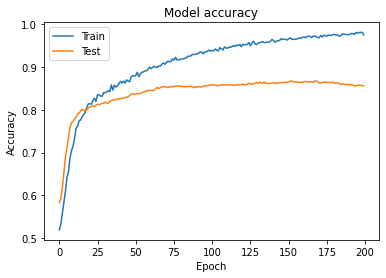

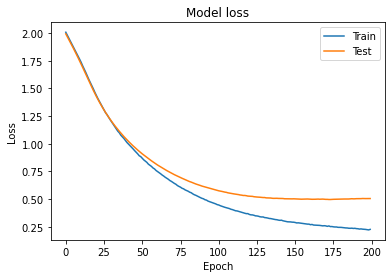

In [ ]:
import matplotlib.pyplot as plt  # it overfits after epoch 11, but starts to learn again after 14

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
model.save('lstm_fr')
loaded_model=tf.keras.models.load_model('lstm_fr')

INFO:tensorflow:Assets written to: lstm_fr/assets


INFO:tensorflow:Assets written to: lstm_fr/assets


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred_valid=(model.predict(X_valid_new)>0.5).astype(int)

In [ ]:
print(classification_report(y_val,y_pred_valid))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       586
           1       0.85      0.87      0.86       614

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



In [ ]:
confusion_matrix(y_val,y_pred_valid)

array([[495,  91],
       [ 82, 532]])

In [ ]:
loaded_model=tf.keras.models.load_model('/content/model1')